In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

In [ ]:
# tocker, weightのカラムが必要
portfolio = pd.read_csv("portfolio_2010.csv")
portfolio.head()

,Ticker,Name,Category,Original Currency,Sector,Share,Market Price per Share,Total Value in original Currency,Total Value in USD,Weight
0,NVDA,NVIDIA,stock,USD,semicon,37,$134.70,"$4,983.90","$5,188.14",0.051881
1,AMD,AMD,stock,USD,semicon,34,$119.21,"$4,053.14","$4,293.86",0.042939
2,ASML,ASML,stock,EUR,semicon,6,? 681.80,"? 4,090.80","$4,273.75",0.042737
3,TSM,TSMC,stock,USD,semicon,20,$197.21,"$3,944.20","$4,126.60",0.041266
4,GOOGL,Google,stock,USD,AI/cloud,20,$191.41,"$3,828.20","$3,922.20",0.039222


## Create Dataframe of my Portfolio

In [ ]:
# Create Ticker List
tickers = portfolio['Ticker'].tolist()
tickers = ['SPY'] + tickers
# Get Past Price Data
data = yf.download(tickers, start='2010-01-01', end='2024-12-23')['Adj Close']
data.shape

[*********************100%***********************]  24 of 24 completed


(3893, 24)

In [ ]:
# 欠損値処理
# Resample all data on a business day basis
cleaned_data = data.resample("B").mean()
# Fill with data from the previous business day (ffill)
cleaned_data.fillna(method="ffill", inplace=True)
cleaned_data.shape

<ipython-input-4-6715e5106a83>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_data.fillna(method="ffill", inplace=True)


(3905, 24)

In [ ]:
cleaned_data.head()

Ticker,7203.T,AMD,AMZN,ASML,BEP,BYDDY,CCI,CSCO,EEM,FSLR,...,MSFT,NVDA,PG,QCOM,SPY,TMO,TSM,VGK,VWO,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,528.769104,9.70,6.6950,23.819910,5.397744,17.182766,25.765423,16.475368,31.084089,135.460007,...,23.347322,0.423923,39.432011,32.068382,86.026451,45.142467,7.353936,29.572039,28.041361,39.594818
2010-01-05,517.214966,9.71,6.7345,24.005461,5.400669,17.197996,26.012606,16.401968,31.309708,137.399994,...,23.354858,0.430113,39.444912,32.840382,86.254166,45.294529,7.322184,29.524685,28.133957,39.749413
2010-01-06,529.448730,9.57,6.6125,24.225382,5.435777,16.748819,25.641840,16.295193,31.375212,140.020004,...,23.211535,0.432864,39.257828,32.519279,86.314919,45.722198,7.296782,29.702259,28.305912,40.092964
2010-01-07,523.331848,9.47,6.5000,23.551874,5.412372,16.271099,25.219025,16.368610,31.193260,140.479996,...,22.970139,0.424381,39.044918,33.462070,86.679253,45.722198,7.055461,29.512840,28.061218,39.967003
2010-01-08,538.284180,9.43,6.6760,22.988338,5.453330,16.273005,25.342607,16.455351,31.440712,139.679993,...,23.128557,0.425298,38.993301,33.796822,86.967712,46.491993,7.049110,29.808802,28.233170,39.806683


In [ ]:
# delete rows include nan
cleaned_data_dropna = cleaned_data.dropna()
port = cleaned_data_dropna
port.shape

(3905, 24)

## Calculate Return

In [ ]:
# Calculate daily returns for each asset
returns = data.pct_change()

# Step 1: 欠損値を削除
returns = returns.dropna()

# Step 2: 行の中に1つでも0が含まれている場合、その行を削除
returns = returns.loc[~(returns == 0).any(axis=1)]

# Display the first few rows of the returns data to confirm
print(returns.head())


Ticker        7203.T       AMD      AMZN      ASML       BEP     BYDDY  \
Date                                                                     
2010-01-05 -0.021851  0.001031  0.005900  0.007790  0.000542  0.000886   
2010-01-06  0.023653 -0.014418 -0.018116  0.009161  0.006501 -0.026118   
2010-01-08  0.028571 -0.004224  0.027077 -0.023927  0.007568  0.000117   
2010-01-12  0.039141 -0.053611 -0.022715  0.001527 -0.011784 -0.006842   
2010-01-13 -0.014580  0.057803  0.013820  0.027752  0.011924 -0.034328   

Ticker           CCI      CSCO       EEM      FSLR  ...      MSFT      NVDA  \
Date                                                ...                       
2010-01-05  0.009594 -0.004455  0.007258  0.014321  ...  0.000323  0.014602   
2010-01-06 -0.014253 -0.006510  0.002092  0.019068  ... -0.006137  0.006397   
2010-01-08  0.004900  0.005299  0.007933 -0.005695  ...  0.006897  0.002161   
2010-01-12 -0.018476 -0.015860 -0.016006 -0.038050  ... -0.006607 -0.033899   
2010-01

<ipython-input-7-2d149f142435>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change()


In [ ]:
returns.shape

(2967, 24)

## Beta

In [ ]:
def calculate_beta(returns, market_column="SPY"):
    market_returns = returns[market_column]
    beta_values = {}
    for asset in returns.columns:
        if asset != market_column:
            covariance = np.cov(returns[asset], market_returns)[0, 1]
            market_variance = np.var(market_returns)
            beta_values[asset] = covariance / market_variance
    return beta_values

beta_values = calculate_beta(returns)

In [ ]:
beta_df = pd.DataFrame.from_dict(beta_values, orient='index', columns=['Beta'])
print(beta_df)

            Beta
7203.T  0.239594
AMD     1.687951
AMZN    1.133780
ASML    1.416412
BEP     0.756656
BYDDY   1.080884
CCI     0.765154
CSCO    1.009758
EEM     1.005806
FSLR    1.231986
GOOGL   1.095770
ISRG    1.144192
JNJ     0.561185
MDT     0.851929
MSFT    1.135486
NVDA    1.688815
PG      0.535829
QCOM    1.227936
TMO     0.945666
TSM     1.087432
VGK     1.031247
VWO     0.961256
XOM     0.878132


## Portfolio Beta

In [ ]:
# type -> dict
def get_portfolio_weights(portfolio):
    weights = dict(zip(portfolio['Ticker'], portfolio['Weight']))
    return weights

portfolio_weights = get_portfolio_weights(portfolio)

In [ ]:
portfolio_weights

{'NVDA': 0.0518814,
 'AMD': 0.0429386,
 'ASML': 0.0427375,
 'TSM': 0.041266,
 'GOOGL': 0.039222,
 'MSFT': 0.0395397,
 'AMZN': 0.0297765,
 'MDT': 0.0304806,
 'ISRG': 0.0301698,
 'TMO': 0.026851,
 'CSCO': 0.026449,
 'CCI': 0.0305235,
 'QCOM': 0.03003,
 '7203.T': 0.0302784,
 'BYDDY': 0.030051815,
 'PG': 0.019922,
 'JNJ': 0.0304092,
 'BEP': 0.020419,
 'FSLR': 0.030342,
 'XOM': 0.0409662,
 'VGK': 0.040432,
 'EEM': 0.0300424,
 'VWO': 0.0302744}

In [ ]:
def calculate_portfolio_beta(beta_values, weights):
    portfolio_beta = sum(beta_values[asset] * weight for asset, weight in weights.items())
    return portfolio_beta

portfolio_beta = calculate_portfolio_beta(beta_values, portfolio_weights)
print(f"Portfolio Beta: {portfolio_beta}")

Portfolio Beta: 0.8172513652599623


## Covariance

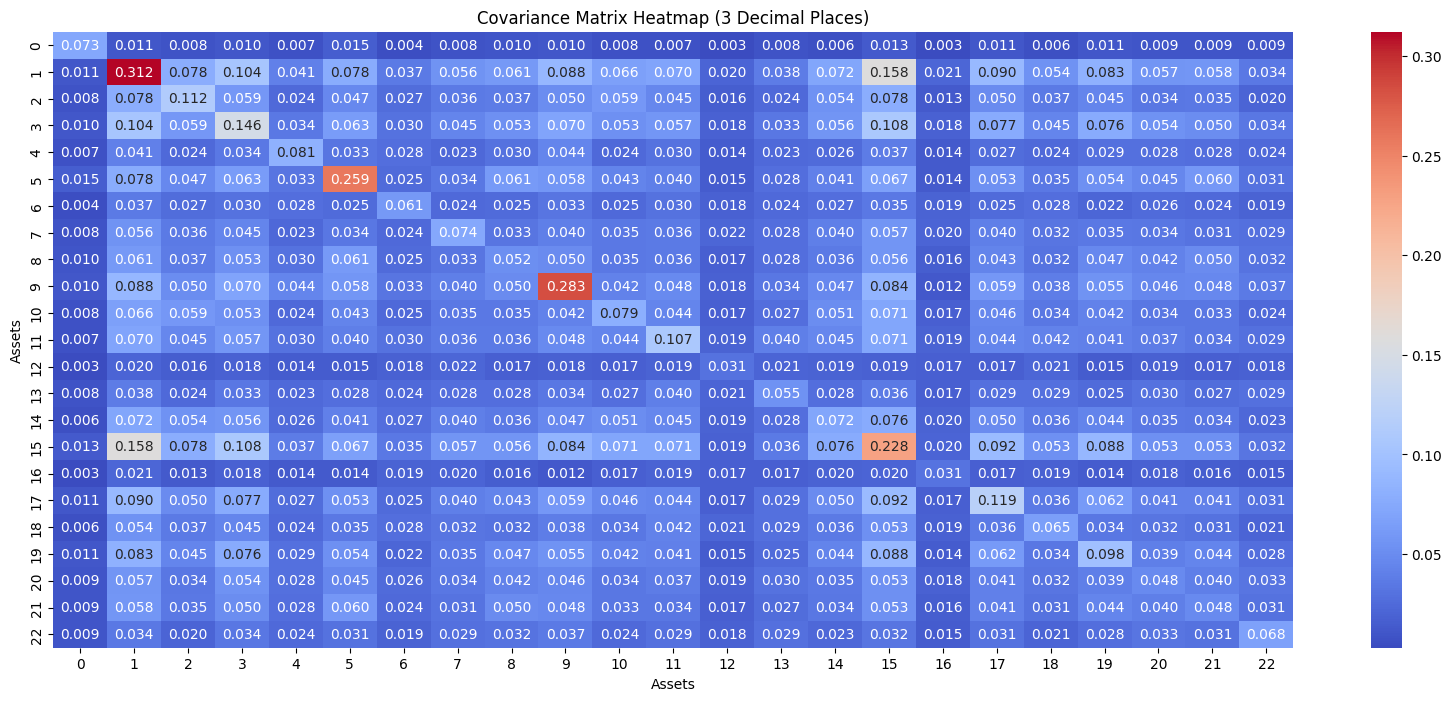

In [ ]:
returns_matrix = returns.to_numpy()
annualized_cov_matrix = np.cov(returns_matrix, rowvar=False) * 252
# Plot the covariance matrix heatmap with 3 decimal places (without rounding)
plt.figure(figsize=(20, 8))
sns.heatmap(annualized_cov_matrix, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
plt.title("Covariance Matrix Heatmap (3 Decimal Places)")
plt.xlabel("Assets")
plt.ylabel("Assets")
plt.show()

## Correlation Coefficient

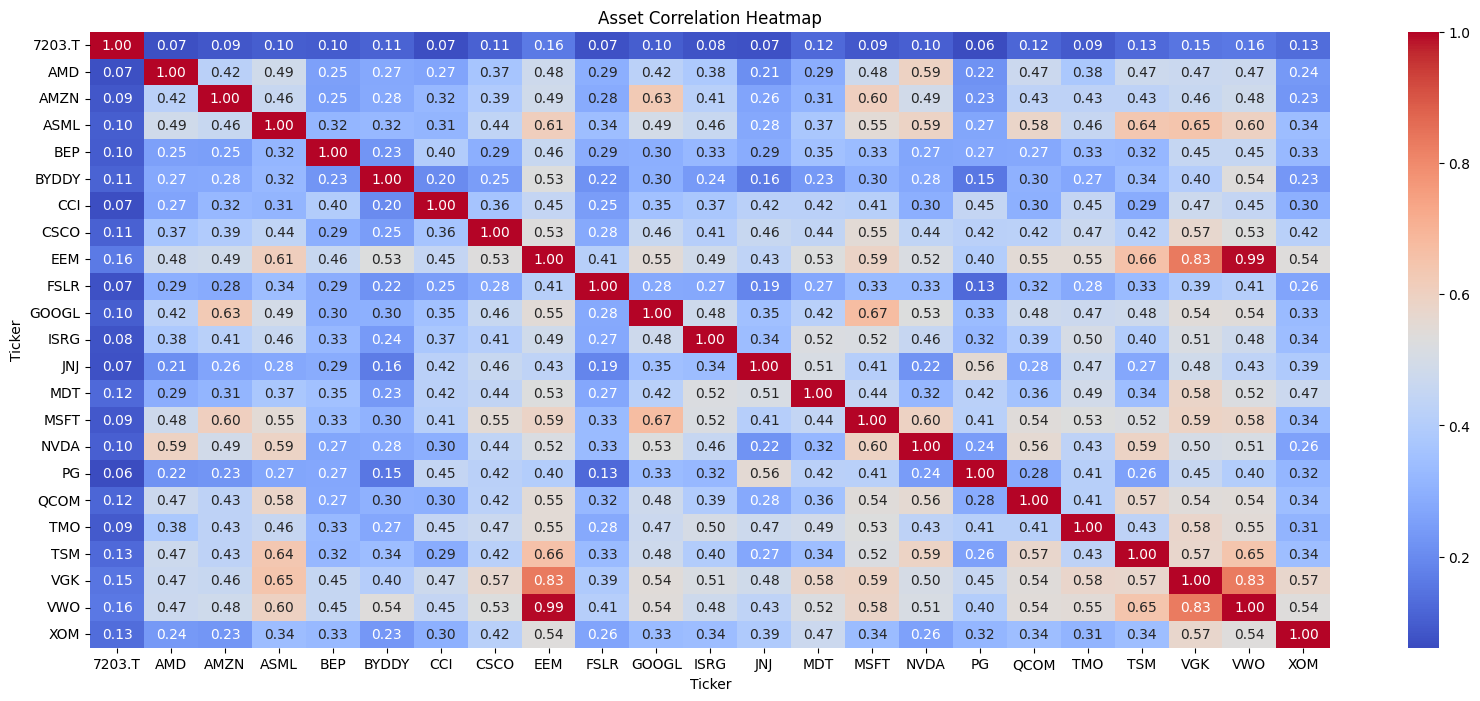

In [ ]:
returns = returns.drop(columns=['SPY'], errors='ignore')
def plot_correlation_heatmap(returns):
    returns = returns.dropna()
    correlation_matrix = returns.corr()
    plt.figure(figsize=(20, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Asset Correlation Heatmap")
    plt.show()

plot_correlation_heatmap(returns)

## Standard Deviation

In [ ]:
def calculate_annualized_portfolio_std(returns, weights):
    weight_array = np.array([weights[asset] for asset in returns.columns if asset in weights])
    annualized_cov_matrix = returns.cov() * 252
    portfolio_variance = np.dot(weight_array.T, np.dot(annualized_cov_matrix, weight_array))
    portfolio_std = np.sqrt(portfolio_variance)
    return portfolio_std

annualized_portfolio_std = calculate_annualized_portfolio_std(returns, portfolio_weights)
print(f"Annualized Portfolio Standard Deviation: {annualized_portfolio_std}")

Annualized Portfolio Standard Deviation: 0.16004139312785587


## Expected Annual Return

In [ ]:
def calculate_expected_return(returns, weights, annualize_factor=252):
    mean_daily_returns = returns.mean()
    expected_daily_return = sum(mean_daily_returns[asset] * weight for asset, weight in weights.items())
    expected_annual_return = expected_daily_return * annualize_factor
    return expected_annual_return

expected_return = calculate_expected_return(returns, portfolio_weights)
print(f"Expected Annual Return: {expected_return}")

Expected Annual Return: 0.15241958143772852


## Sharp Ratio

In [ ]:
def calculate_sharpe_ratio(expected_return, portfolio_std, risk_free_rate=0.04):
    sharpe_ratio = (expected_return - risk_free_rate) / portfolio_std
    return sharpe_ratio

sharpe_ratio = calculate_sharpe_ratio(expected_return, annualized_portfolio_std)
print(f"Sharpe Ratio: {sharpe_ratio}")


Sharpe Ratio: 0.7024406576360989


## Efficient Frontier

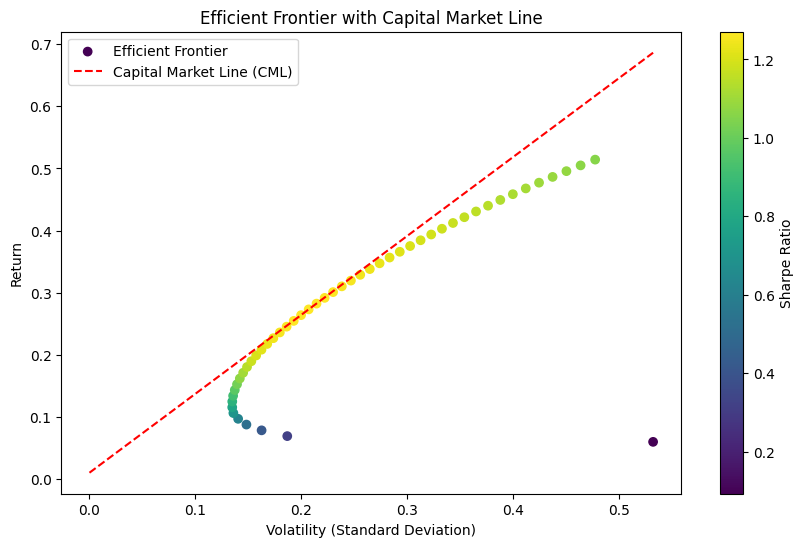

In [ ]:
def calculate_efficient_frontier(returns, risk_free_rate=0.04):
    mean_returns = returns.mean() * 252  # 年率換算
    cov_matrix = returns.cov() * 252  # 年率換算
    num_assets = len(mean_returns)
    results = {
        "returns": [],
        "volatility": [],
        "weights": []
    }

    def portfolio_performance(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return portfolio_return, portfolio_volatility

    def negative_sharpe_ratio(weights):
        p_return, p_volatility = portfolio_performance(weights)
        return -(p_return - risk_free_rate) / p_volatility

    def minimize_volatility(weights):
        return portfolio_performance(weights)[1]

    # 制約と境界
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))

    # 効率的フロンティアの生成
    for target_return in np.linspace(mean_returns.min(), mean_returns.max(), 50):
        constraints = ({'type': 'eq', 'fun': lambda x: portfolio_performance(x)[0] - target_return},
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        result = minimize(minimize_volatility, num_assets * [1. / num_assets, ], args=(),
                          method='SLSQP', bounds=bounds, constraints=constraints)
        if result.success:
            p_return, p_volatility = portfolio_performance(result.x)
            results["returns"].append(p_return)
            results["volatility"].append(p_volatility)
            results["weights"].append(result.x)

    return results

def plot_efficient_frontier_with_cml(results, risk_free_rate=0.01):
    # 効率的フロンティア
    plt.figure(figsize=(10, 6))
    plt.scatter(results['volatility'], results['returns'], c=(np.array(results['returns']) - risk_free_rate) / np.array(results['volatility']),
                cmap='viridis', marker='o', label='Efficient Frontier')

    # CMLの計算をフロンティア全体に拡張
    max_sharpe_idx = np.argmax((np.array(results['returns']) - risk_free_rate) / np.array(results['volatility']))
    max_sharpe_vol = results['volatility'][max_sharpe_idx]
    max_sharpe_ret = results['returns'][max_sharpe_idx]
    cml_x = np.linspace(0, max(results['volatility']), 100)
    cml_y = risk_free_rate + (max_sharpe_ret - risk_free_rate) / max_sharpe_vol * cml_x
    plt.plot(cml_x, cml_y, color='red', linestyle='--', label='Capital Market Line (CML)')

    plt.colorbar(label='Sharpe Ratio')
    plt.title('Efficient Frontier with Capital Market Line')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

# 効率的フロンティアを計算してプロット
efficient_frontier_results = calculate_efficient_frontier(returns)
plot_efficient_frontier_with_cml(efficient_frontier_results)

In [ ]:
# 修正後のポートフォリオを新しいCSVに保存
cleaned_data.to_csv('1224_1759.csv', index=False)